In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tensorflow.keras.utils import plot_model

In [3]:
# Step 1: Generate Data for Regression
x_data = np.linspace(0, 2, 100).reshape(-1, 1)
y_data = np.exp(-2 * x_data)  # Exact solution of the ODE

In [4]:
# Step 2: Fit a Polynomial Regression Model
poly = PolynomialFeatures(degree=3)  # Using a cubic polynomial
x_poly = poly.fit_transform(x_data)  # Transform x into polynomial features

regressor = LinearRegression()
regressor.fit(x_poly, y_data)  # Fit polynomial regression

# Print polynomial coefficients
print("Regression Coefficients:", regressor.coef_)

Regression Coefficients: [[ 0.         -1.65464973  1.03502973 -0.225326  ]]


In [5]:
# Step 3: Define the Neural Network Model with Regression-Based Initialization
class NeuralNetwork(tf.keras.Model):
    def __init__(self, regression_coeffs):
        super(NeuralNetwork, self).__init__()
        self.hidden = tf.keras.layers.Dense(10, activation="tanh")  # Hidden layer with 10 neurons
        self.output_layer = tf.keras.layers.Dense(1)

        # Regression-Based Initialization
        self.regression_coeffs = regression_coeffs

    def call(self, x):
        x = self.hidden(x)
        x = self.output_layer(x)
        return x

In [6]:
# Step 4: Define the Loss Function
def loss_function(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        dy_dx = tape.gradient(y_pred, x)  # Compute dy/dx using automatic differentiation

    # Loss: ODE constraint + Boundary condition
    equation_loss = tf.reduce_mean(tf.square(dy_dx + 2 * y_pred))  # Enforcing ODE
    boundary_loss = tf.square(model(tf.constant([[0.0]], dtype=tf.float32)) - 1)  # Enforcing y(0) = 1

    return equation_loss + boundary_loss  # Total loss

In [7]:
# Step 5: Training Function
def train_model(model, optimizer, epochs=1000):
    x_train = tf.convert_to_tensor(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(model, x_train)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

In [8]:
# Step 6: Initialize Model with Regression-Based Weights
model = NeuralNetwork(regressor.coef_)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Train the Model
train_model(model, optimizer, epochs=1000)

Epoch 0, Loss: [[1.0521245]]
Epoch 100, Loss: [[0.03073975]]
Epoch 200, Loss: [[0.00656783]]
Epoch 300, Loss: [[0.00268193]]
Epoch 400, Loss: [[0.00194411]]
Epoch 500, Loss: [[0.00159803]]
Epoch 600, Loss: [[0.00130163]]
Epoch 700, Loss: [[0.00098376]]
Epoch 800, Loss: [[0.00071088]]
Epoch 900, Loss: [[0.00052071]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


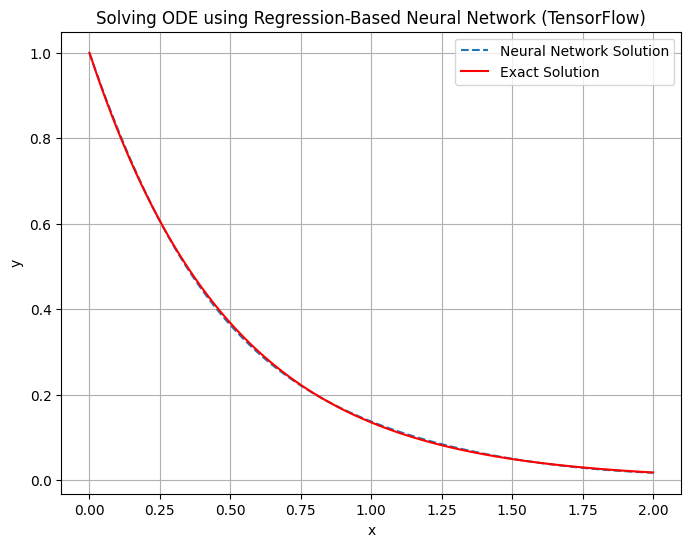

In [9]:
# Step 7: Evaluate and Plot the Results
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_pred = model.predict(x_test)
y_true = np.exp(-2 * x_test)  # Exact solution

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_pred, label="Neural Network Solution", linestyle="dashed")
plt.plot(x_test, y_true, label="Exact Solution", color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solving ODE using Regression-Based Neural Network (TensorFlow)")
plt.legend()
plt.grid(True)
plt.show()


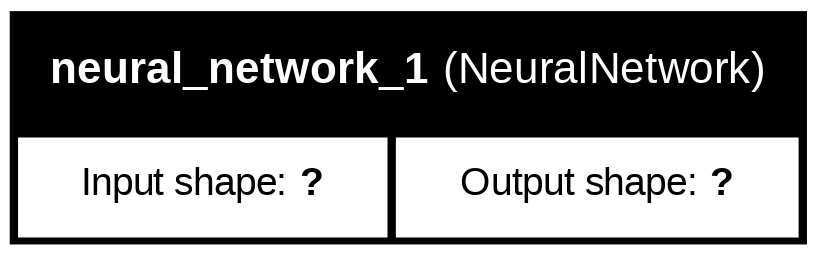

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="network_plot.png")